# E-commerce Sales Analytics

## Introduction
Sales is the most important factor in e-commerce company as it generates revenue from the platform fee from each transaction.

In this project, we aim to *Explore* order items data to find interesting insights to Olist to improve their sales.

This data used is Brazilian E-Commerce Public Dataset by Olist which is download from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

## Exploratory Data Analysis (EDA)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

pd.set_option('display.max_columns', None)

In [2]:
# where do the customers stay
customer_data = pd.read_csv(r'data/olist_customers_dataset.csv')

# geolocation longitute and latitue of the customers
geolocation_data = pd.read_csv(r'data/olist_geolocation_dataset.csv')

# order details with product id, seller id, shipping info, product price and freight fee
order_items_data = pd.read_csv(r'data/olist_order_items_dataset.csv')

# order with payment details like payment type, installments and payment value
order_payments_data = pd.read_csv(r'data/olist_order_payments_dataset.csv')

# order review id with review score, title, message, creation date and answer timestamp
order_reviews_data = pd.read_csv(r'data/olist_order_reviews_dataset.csv')

# order status with customer id, order purchase timestamp, approved time, delivery carrier date, 
# delivery to customer date and order estimated delivery date  
orders_data = pd.read_csv(r'data/olist_orders_dataset.csv')

# product info with id, category name, length product name, length product description, quantity of product photos,
# product weight, product length in cm, product height in cm, product width in cm
products_data = pd.read_csv(r'data/olist_products_dataset.csv')

# sellers info with seller zip code, city and state
sellers_data = pd.read_csv(r'data/olist_sellers_dataset.csv')

# product category translation from brazilian to english
product_category_name_translation_data = pd.read_csv(r'data/product_category_name_translation.csv')

As the data is incomplete for year 2016 and 2018, we will only use 2017 data in this project.

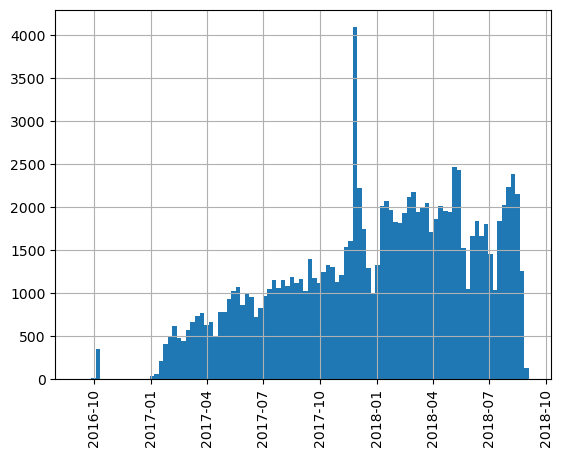

In [3]:
# translate the products data from Brasilian to English
products_data = pd.merge(products_data, product_category_name_translation_data, how='left', on='product_category_name').drop_duplicates()
products_data.drop('product_category_name', axis=1, inplace=True)
products_data.rename(columns = {'product_category_name_english' : 'product_category_name'}, inplace=True)

# generate master dataframe
main_df = pd.merge(order_items_data, orders_data[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']], how='left', on='order_id')
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
main_df['order_purchase_month'] = main_df['order_purchase_timestamp'].dt.month
main_df['order_purchase_year'] = main_df['order_purchase_timestamp'].dt.year
main_df['order_purchase_hour'] = main_df['order_purchase_timestamp'].dt.hour

main_df['order_purchase_timestamp'].hist(bins=100)
plt.xticks(rotation='vertical')
plt.show()

In [4]:
# we only analyse orders that are delivered
main_df = main_df[main_df['order_status']=='delivered']

# filter to 2017 data
main_df = main_df[main_df['order_purchase_year']==2017]

main_df = pd.merge(main_df, products_data[['product_id', 'product_category_name']], how='left', on='product_id')

# there are duplications on customer_data location, we will use latest entry as the newest customer location
customer_data = customer_data.drop_duplicates('customer_unique_id', keep='last')
main_df = pd.merge(main_df, customer_data, how='left', on='customer_id')

# there are duplications on order_reviews location, we will use latest entry as the review score of the order_id
order_reviews_data = order_reviews_data.drop_duplicates('order_id', keep='last')
main_df = pd.merge(main_df, order_reviews_data[['order_id', 'review_score'
                                              ]], how='left', on='order_id')
main_df.drop_duplicates(inplace=True)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49556 entries, 0 to 49555
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  49556 non-null  object        
 1   order_item_id             49556 non-null  int64         
 2   product_id                49556 non-null  object        
 3   seller_id                 49556 non-null  object        
 4   shipping_limit_date       49556 non-null  object        
 5   price                     49556 non-null  float64       
 6   freight_value             49556 non-null  float64       
 7   customer_id               49556 non-null  object        
 8   order_status              49556 non-null  object        
 9   order_purchase_timestamp  49556 non-null  datetime64[ns]
 10  order_purchase_month      49556 non-null  int32         
 11  order_purchase_year       49556 non-null  int32         
 12  order_purchase_hou

The are missing informations for product_category_name and review_score accounted for < 4%. Let's drop these features.

In [5]:
main_df.isna().sum()/main_df['order_id'].count()*100

order_id                    0.000000
order_item_id               0.000000
product_id                  0.000000
seller_id                   0.000000
shipping_limit_date         0.000000
price                       0.000000
freight_value               0.000000
customer_id                 0.000000
order_status                0.000000
order_purchase_timestamp    0.000000
order_purchase_month        0.000000
order_purchase_year         0.000000
order_purchase_hour         0.000000
product_category_name       1.773751
customer_unique_id          3.947050
customer_zip_code_prefix    3.947050
customer_city               3.947050
customer_state              3.947050
review_score                0.855598
dtype: float64

In [6]:
main_df = main_df.dropna()

Olist generated total revenue of 5611941.0 in year 2017. 

The revenue trend shows that the highest revenue happens in month November probably due to the upcoming festive season like thanksgiving festival and christmas.
November is also the month of Black Friday which is one of the largest sale of the year.

In [7]:
np.round(main_df['price'].sum())

5611941.0

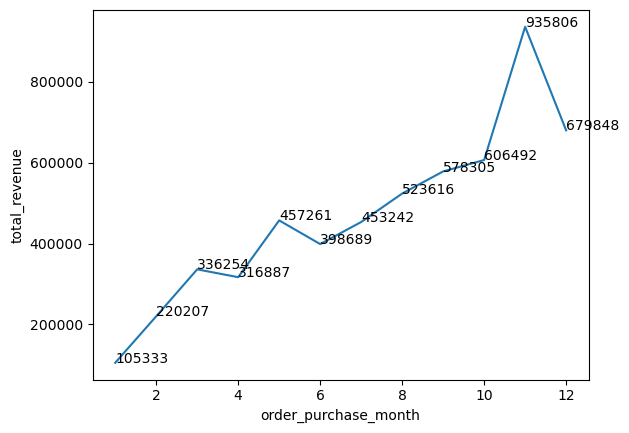

In [8]:
revenue_month = main_df.groupby(['order_purchase_year', 'order_purchase_month'])['price'].sum().reset_index()
revenue_month = revenue_month.groupby('order_purchase_month')['price'].mean().reset_index()
revenue_month.rename(columns = {'price' : 'total_revenue'}, inplace=True)

ax = sns.lineplot(revenue_month, x='order_purchase_month', y='total_revenue')

# label points on the plot
for x, y in zip(revenue_month['order_purchase_month'], revenue_month['total_revenue']):
    # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x, # x-coordinate position of data label
             y = y-150, # y-coordinate position of data label, adjusted to be 150 below the data point
             s = '{:.0f}'.format(y)) # data label, formatted to ignore decimals
    
plt.savefig(r'plot/revenue_time_series.jpeg')

Olist generated total sales of 43658 in year 2017. 

The sales trend has the same trend as revenue trend.

In [9]:
np.round(main_df['order_id'].count())

46358

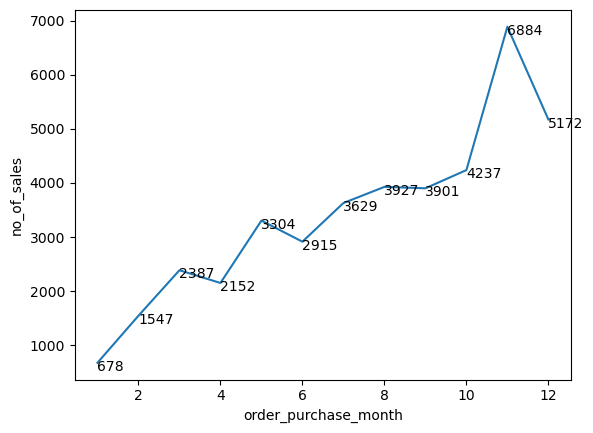

In [10]:
sales_month = main_df.groupby(['order_purchase_year', 'order_purchase_month'])['order_id'].nunique().reset_index()
sales_month = sales_month.groupby('order_purchase_month')['order_id'].mean().reset_index()
sales_month.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.lineplot(sales_month, x='order_purchase_month', y='no_of_sales')

# label points on the plot
for x, y in zip(sales_month['order_purchase_month'], sales_month['no_of_sales']):
    # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x, # x-coordinate position of data label
             y = y-150, # y-coordinate position of data label, adjusted to be 150 below the data point
             s = '{:.0f}'.format(y)) # data label, formatted to ignore decimals
    
plt.savefig(r'plot/sales_time_series.jpeg')

As the product listing did not specify when it was listed on the platform, let's assume the listings throughout the years are similar. The top 5 product_category listed on Olist platform are bed_bath_table, sports_leisure, furniture_decor, healthy_beauty and housewares.

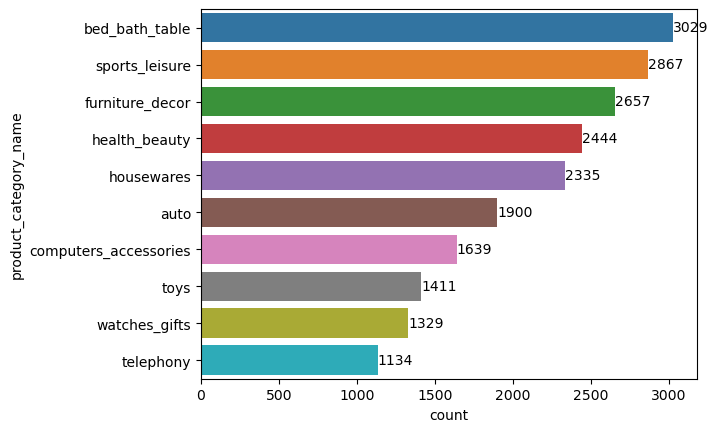

In [11]:
# top 10 product category listed in olist
top_products_store = products_data['product_category_name'].value_counts().reset_index().head(10)

ax = sns.barplot(top_products_store, x='count', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_listed_product_category.jpeg')

The top listed product_category remains consistent throught out the year for each product_category.

furniture_decor used to be the top 1 listed product_category in Q1 but overtook by bed_bath_table product_category from Q2 onwards.

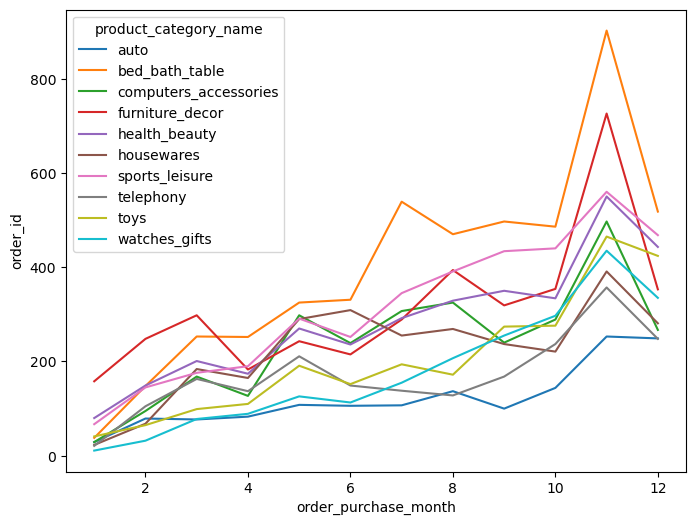

In [12]:
top_products_store_trend = main_df[main_df['product_category_name'].isin(top_products_store['product_category_name'])].groupby(['product_category_name', 'order_purchase_month'])['order_id'].count().reset_index()

plt.figure(figsize=(8, 6))
sns.lineplot(data=top_products_store_trend, x='order_purchase_month', y='order_id', hue='product_category_name')

plt.savefig(r'plot/top_listed_product_category_trend.jpeg')

Top 5 product_category that brings the highest sales are bed_bath_table, furniture_decor, sports_leisure, healthy_beauty and computers_accessories. 

Despite auto and telephony were the top listed products on the platform. However, they did not contribute to the top 10 sales product_category. bed_bath_table is the top 1 sales product_category (~5000 sales) with 1000 more sales volume than the top 2, 3 and 4 product_category (3000-4000 sales). The top 5-10 product_category sales are in the same range (2000-3000 sales).

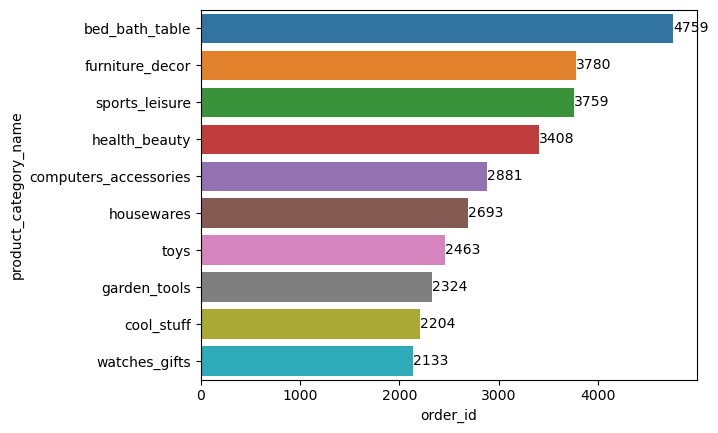

In [13]:
# top 10 product category with highest sales
top_products_sales = main_df.groupby('product_category_name')['order_id'].count().reset_index().sort_values('order_id', ascending=False).head(10)

ax = sns.barplot(top_products_sales, x='order_id', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_sales_product_category.jpeg')

The top 10 product_category contribute to ~66% of total sales on Olist.

66.0

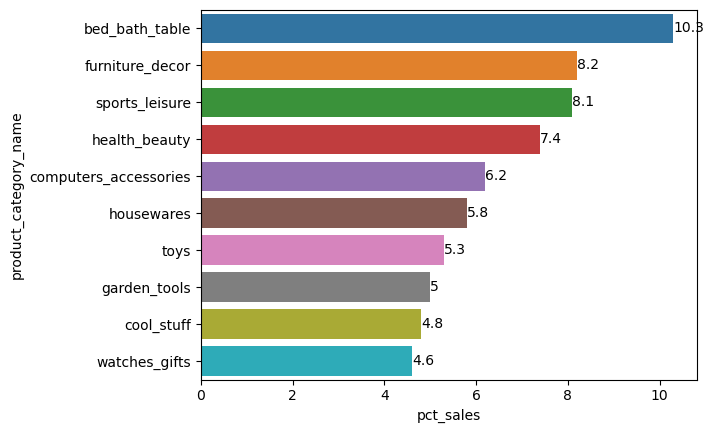

In [14]:
top_products_sales['pct_sales'] = np.round(top_products_sales['order_id']/main_df['order_id'].count()*100, 1)

ax = sns.barplot(top_products_sales, x='pct_sales', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_sales_product_category_percentage.jpeg')

np.round(top_products_sales['pct_sales'].sum(), 0)

The top sales product_category remains consistent having high sales throught out the year.

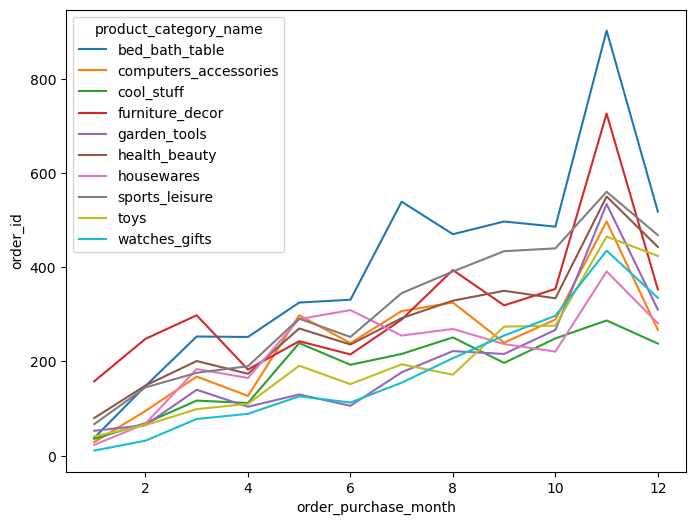

In [15]:
top_products_store_trend = main_df[main_df['product_category_name'].isin(top_products_sales['product_category_name'])].groupby(['product_category_name', 'order_purchase_month'])['order_id'].count().reset_index()

plt.figure(figsize=(8, 6))
sns.lineplot(data=top_products_store_trend, x='order_purchase_month', y='order_id', hue='product_category_name')

plt.savefig(r'plot/top_listed_product_category_trend.jpeg')

Top 5 product category that brings the highest revenues are watches_gifts, bed_bath_table, healthy_beauty, sports_leisure and computers_accessories.

The top 1 revenue product_category (watches_gifts) is not the same as top sales product_category.
auto is not in top sales but apppear to be in top revenue product_category. housewares is not inside top revenue despite it is on top sales product_category.

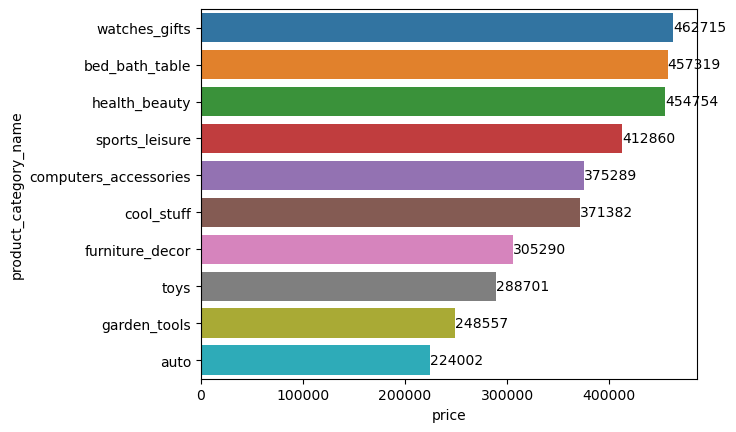

In [16]:
# top 10 product category with highest revenue
top_products_revenue = main_df.groupby('product_category_name')['price'].sum().reset_index().sort_values('price', ascending=False).head(10)

ax = sns.barplot(top_products_revenue, x='price', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_revenue_product_category.jpeg')

The Average Order Value (AOV) on Olist is 121.

The top 5 product_category with highest AOV are computers, agro_industry_and_commerce, small_appliances, musical_instruments and art. The top AOV product_category list is different from top sales and revenue product_category. We can observe that the top AOV products are mainly more expensive items.

In [17]:
np.round(main_df['price'].mean(), 0)

121.0

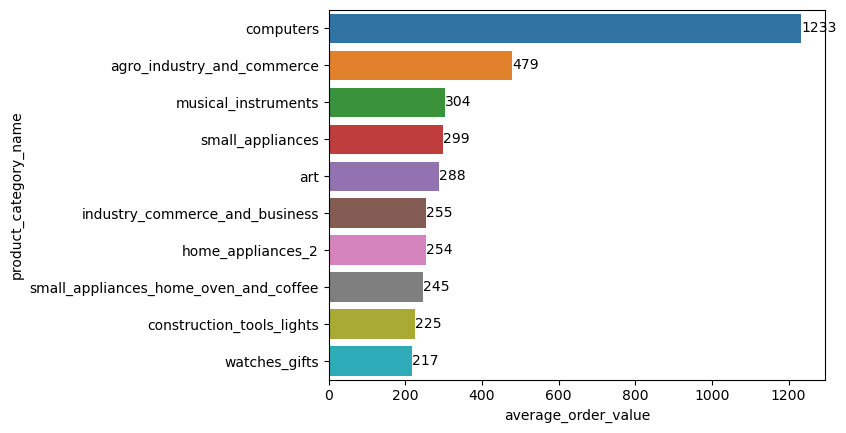

In [18]:
aov_sales = main_df.groupby('product_category_name').aggregate({'order_id' : 'count',
                                                                'price' : 'sum' 
                                                              }).reset_index()
aov_sales.rename(columns = {'order_id' : 'no_of_sales',
                            'price' : 'revenue'
                           }, inplace=True)
aov_sales['average_order_value'] = np.round(aov_sales['revenue']/aov_sales['no_of_sales'], 0)
top_aov_sales =  aov_sales.sort_values('average_order_value', ascending=False).head(10)

ax = sns.barplot(top_aov_sales, x='average_order_value', y='product_category_name')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_aov_product_category.jpeg')

Majority of the payments made in the platform is made via credit_card follows by boreto (Boleto bancário) which is an official Brazilian payment method regulated by the Central Bank of Brazil.

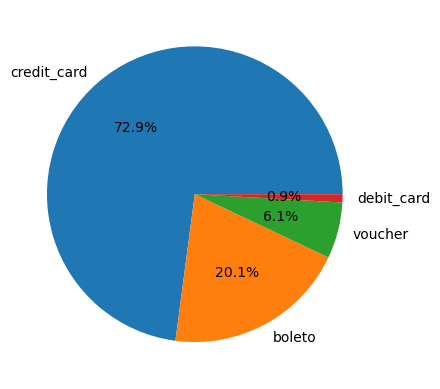

In [19]:
payment_data = order_payments_data[(order_payments_data['order_id'].isin(main_df['order_id']))]
payment_methods = payment_data['payment_type'].value_counts().reset_index()
payment_methods['payment_pct'] = payment_methods['count']*100/payment_methods['count'].sum()

fig, ax = plt.subplots()
ax.pie(payment_methods['payment_pct'], labels=payment_methods['payment_type'], autopct='%1.1f%%')

plt.savefig(r'plot/payment_methods.jpeg')

The no_of_seller follows the same trend as revenue_trend and sales_trend. It seems that when there are more sales happening, more sellers also become active on Olist.

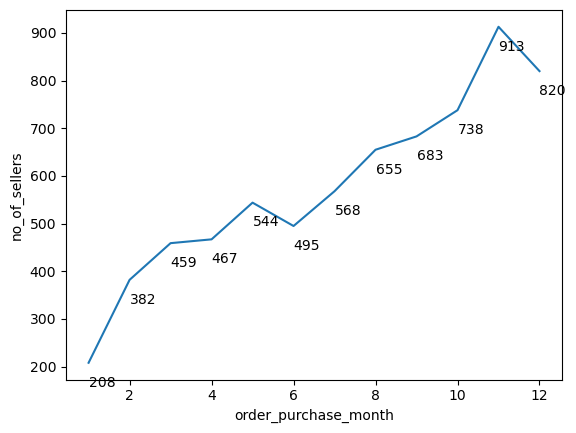

In [20]:
sellers_trend = main_df.groupby(['order_purchase_month'])['seller_id'].nunique().reset_index()
sellers_trend.rename(columns = {'seller_id' : 'no_of_sellers'}, inplace=True)

ax = sns.lineplot(sellers_trend, x='order_purchase_month', y='no_of_sellers')

# label points on the plot
for x, y in zip(sellers_trend['order_purchase_month'], sellers_trend['no_of_sellers']):
    # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x, # x-coordinate position of data label
             y = y-50, # y-coordinate position of data label, adjusted to be 150 below the data point
             s = '{:.0f}'.format(y)) # data label, formatted to ignore decimals
    
plt.savefig(r'plot/sellers_time_series.jpeg')

The average review rating is 4.1 star.

Majority of the reviews is given 5-star follows by 4-star and 1-star. It appears that customers are less likely to write 2-star and 3-star review in a 5-star range.

In [21]:
main_df['review_score'].mean()

4.108050390439622

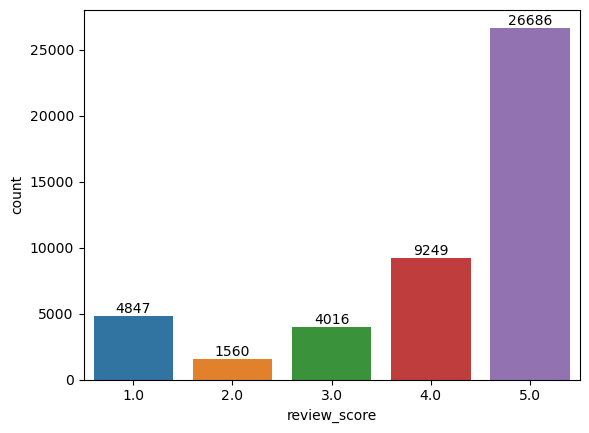

In [22]:
# order reviews
order_reviews = main_df['review_score'].value_counts().reset_index().sort_values('review_score')

ax = sns.barplot(order_reviews, x='review_score', y='count')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/review_score_counts.jpeg')

From the scatterplot, we can see that higher no of sales happen on review score between 3.5 to 4-5 star for both seller and product review. We can also see that review_score for sellers/products do not correlate directly with no_of_sales with pearson's correlation score < 0.01. Despite low correlation score, we can see that more sales happening on products with review score between 3.5-4.5.

In [23]:
sellers_sales_review = main_df.groupby('seller_id').aggregate({'order_id' : 'nunique',
                                                               'review_score' : 'mean'
                                                              }).reset_index().sort_values('order_id', ascending=False)
sellers_sales_review.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)
sellers_sales_review.sort_values('review_score', ascending=False, inplace=True)

In [24]:
sellers_sales_review['review_score'].corr(sellers_sales_review['no_of_sales'])

0.007250957071221042

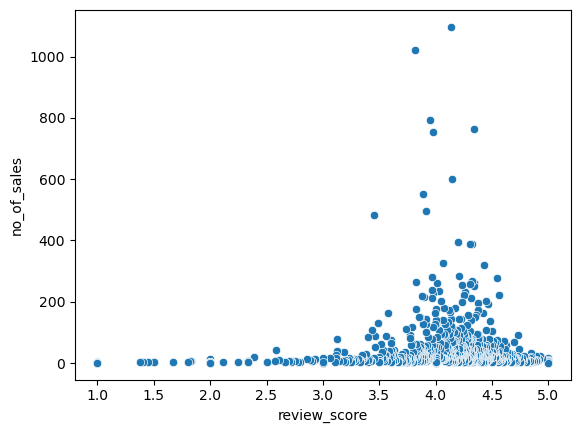

In [25]:
sns.scatterplot(sellers_sales_review, x='review_score', y='no_of_sales')
plt.savefig(r'plot/seller_review_score_sales_correlation.jpeg')

In [26]:
products_sales_review = main_df.groupby('product_id').aggregate({'order_id' : 'nunique',
                                                                 'review_score' : 'mean'
                                                               }).reset_index().sort_values('order_id', ascending=False)
products_sales_review.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)
products_sales_review.sort_values('review_score', ascending=False, inplace=True)

In [27]:
products_sales_review['review_score'].corr(products_sales_review['no_of_sales'])

0.0021150269651650493

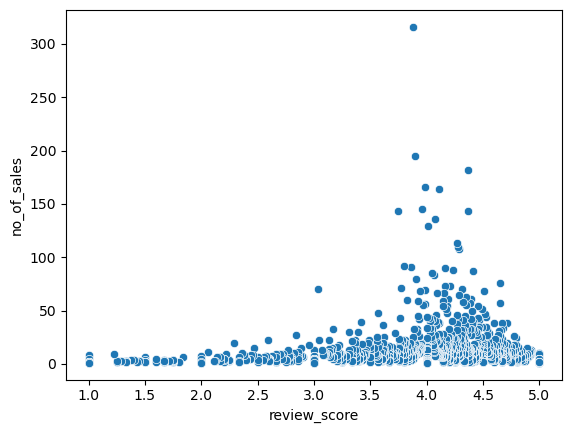

In [28]:
sns.scatterplot(products_sales_review, x='review_score', y='no_of_sales')
plt.savefig(r'plot/product_review_score_sales_correlation.jpeg')

There is no repeated customers on Olist in 2017.

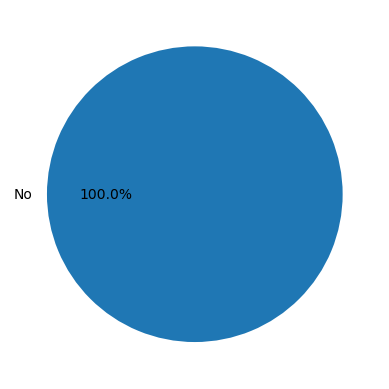

In [29]:
customers_frequency = main_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customers_frequency['repeated_customers'] = np.where(customers_frequency['order_id']>1, 'Yes', 'No')

repeated_customer = customers_frequency['repeated_customers'].value_counts().reset_index()
repeated_customer['repeated_customers_pct'] = repeated_customer['count']*100/repeated_customer['count'].sum()

fig, ax = plt.subplots()
ax.pie(repeated_customer['repeated_customers_pct'], labels=repeated_customer['repeated_customers'], autopct='%1.1f%%')

plt.savefig(r'plot/repeated_customers_pct.jpeg')

Most freight fee is around ~16.

In [30]:
main_df['freight_value'].describe()

count    46358.000000
mean        19.414147
std         14.268941
min          0.000000
25%         13.390000
50%         16.110000
75%         20.080000
max        314.400000
Name: freight_value, dtype: float64

C:\Users\a\anaconda3\envs\data-science-gpu-3.8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


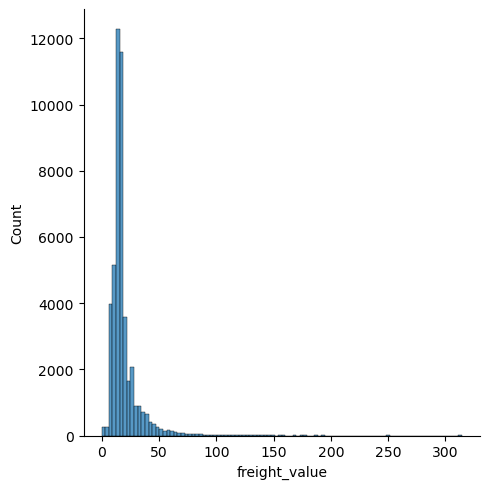

In [31]:
# average freight fee
sns.displot(main_df['freight_value'], bins=100)

Most order has price less than 100

In [32]:
main_df['price'].describe()

count    46358.000000
mean       121.056592
std        185.607127
min          1.200000
25%         39.900000
50%         72.990000
75%        134.900000
max       6735.000000
Name: price, dtype: float64

C:\Users\a\anaconda3\envs\data-science-gpu-3.8\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


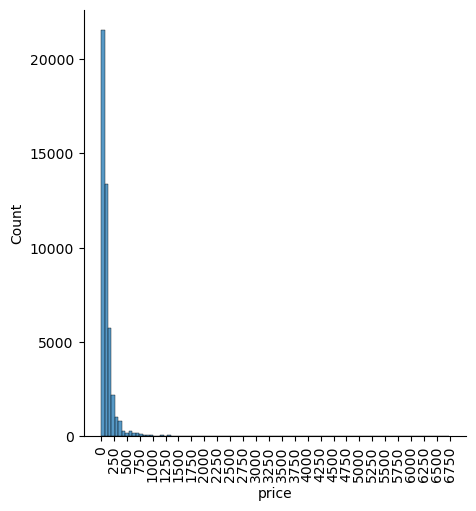

In [33]:
# average order fee
ax = sns.displot(main_df['price'], bins=100)
ax.set(xticks = np.arange(0, 7000, 250))
ax.set_xticklabels(np.arange(0, 7000, 250), rotation=90)

Most sales happen after 10:00 AM and lasted until 12:00 AM midnight.

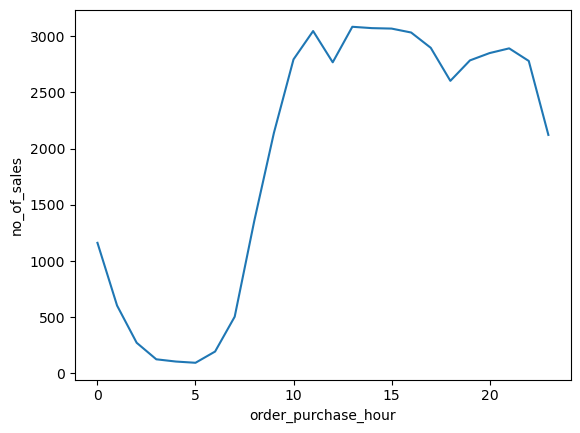

In [34]:
sales_hour = main_df.groupby(['order_purchase_year', 'order_purchase_hour'])['order_id'].count().reset_index()
sales_hour = sales_hour.groupby('order_purchase_hour')['order_id'].mean().reset_index()
sales_hour.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.lineplot(sales_hour, x='order_purchase_hour', y='no_of_sales')

plt.savefig(r'plot/transactions_time.jpeg')

Most customers stay at sao paulo city and SP states.

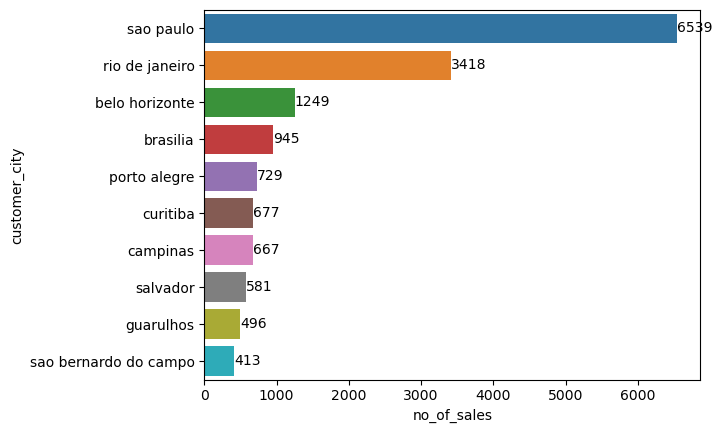

In [35]:
sales_city = main_df.groupby(['customer_city'])['order_id'].count().reset_index().sort_values('order_id', ascending=False).head(10)
sales_city.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.barplot(sales_city, x='no_of_sales', y='customer_city')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_customers_city.jpeg')

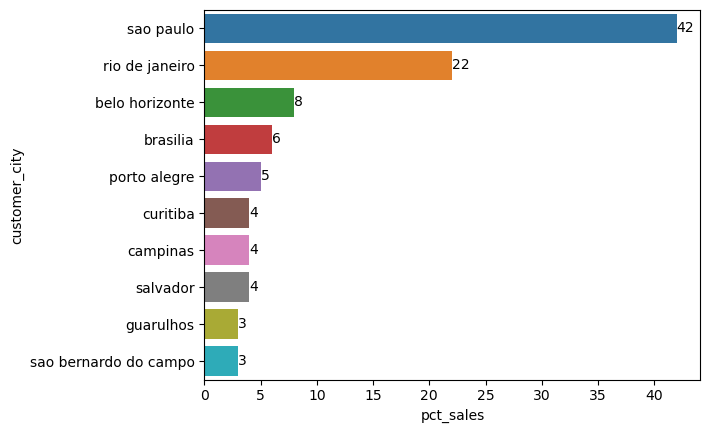

In [49]:
sales_city['pct_sales'] = np.round(sales_city['no_of_sales']*100/sales_city['no_of_sales'].sum(), 0)

ax = sns.barplot(sales_city, x='pct_sales', y='customer_city')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_customers_city_pct.jpeg')

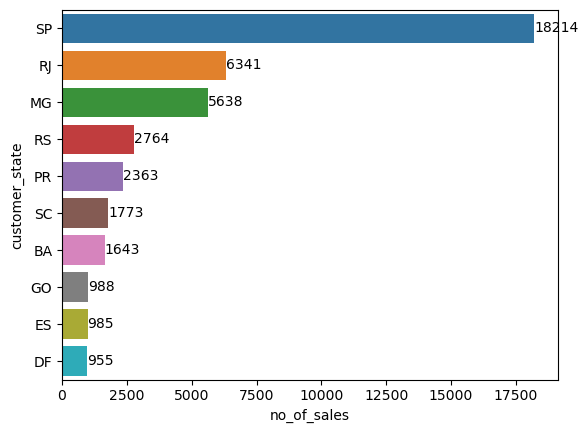

In [36]:
sales_state = main_df.groupby(['customer_state'])['order_id'].count().reset_index().sort_values('order_id', ascending=False).head(10)
sales_state.rename(columns = {'order_id' : 'no_of_sales'}, inplace=True)

ax = sns.barplot(sales_state, x='no_of_sales', y='customer_state')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_customers_state.jpeg')

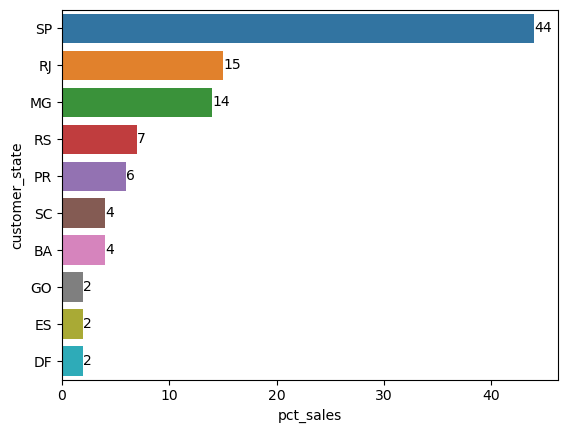

In [52]:
sales_state['pct_sales'] = np.round(sales_state['no_of_sales']*100/sales_state['no_of_sales'].sum(), 0)

ax = sns.barplot(sales_state, x='pct_sales', y='customer_state')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.savefig(r'plot/top_customers_state_pct.jpeg')

## Insights and Findings

These are the insights and findings from the e-commerce analytics:
- Most of the transactions happened from 10 AM till midnight
- November is the month with highest transactions
- High review scores of sellers/products do not translate to higher sales with correlation score < 0.01. Despite low correlation score, there are more sales happening on products with review score between 3.5-4.5
- Top payment methods are credit_card follows by boreto
- These are the top 10 products category with highest sales on the platform: bed_bath_table, furniture_decor, sorts_leisure, health_beauty, computers_accessories, housewares, toys, garden_tools, cool_stuff and watches_gifts
- bed_bath_table has the highest sales but it is not the highest AOV which means customers purchased more bed_bath_table items but does not spend more money on these items. Instead, customers spend more money on computer_accessories
- Top 3 sales are made from customers from these cities: sao paulo, rio de janeiro, and belo horizonte. Similarly, top 3 sales are made from these states: SP, RJ and MG. Merchants would want to target these cities or states to boost overall sales as majority customers live here
- There is 0 customer retention in 2017
- More sellers become more active on Olist and more sales happening when there are more sellers

## Product Design and Recommendations

There are the recommendations that Olist can take to improve overall sales:
- Merchants need to do flash sales after 10 AM for effective marketing as most transactions happen after 10 AM till midnight
- Merchants should allow customers to make payments by these two methods namely credit_card and boreto to stay competitive in the market
- Merchants should aim to get ratings between 3.5-4.5 as most sales happen to product/seller with this review score. Olist should incentivise customers to give review score on the platform
- Olist should create a loyalty programme to improve its customer retention rate
- 42% customers stay at sao paolo contributes follows by 22% customers stay at rio de janeiro. Olist should prioritise these cities in their sales strategy like sales, better shipping, etc.
- The higest profitable items (high AOV) are not the top sales items on Olist. Olist should consider promoting these high AOV product_category more on the platform to improve overall revenue